In [1]:
import pandas as pd
import numpy as np

from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Obtaining data

In [2]:
now_time = datetime.now()
start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
print(start_time, now_time)

data = pdr.get_data_yahoo('AAPL', start_time, now_time)
data

2018-01-14 00:00:00 2023-01-14 02:54:15.959407
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-16,44.474998,44.847500,44.035000,44.047501,41.884754,118263600
2018-01-17,44.037498,44.812500,43.767502,44.775002,42.576542,137547200
2018-01-18,44.842499,45.025002,44.562500,44.814999,42.614571,124773600
2018-01-19,44.652500,44.895000,44.352501,44.615002,42.424385,129700400
2018-01-22,44.325001,44.445000,44.150002,44.250000,42.077312,108434400
...,...,...,...,...,...,...
2023-01-09,130.470001,133.410004,129.889999,130.149994,130.149994,70790800
2023-01-10,130.259995,131.259995,128.119995,130.729996,130.729996,63896200
2023-01-11,131.250000,133.509995,130.460007,133.490005,133.490005,69458900


In [3]:
# Check for missing values
data.isnull().sum()/len(data)

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

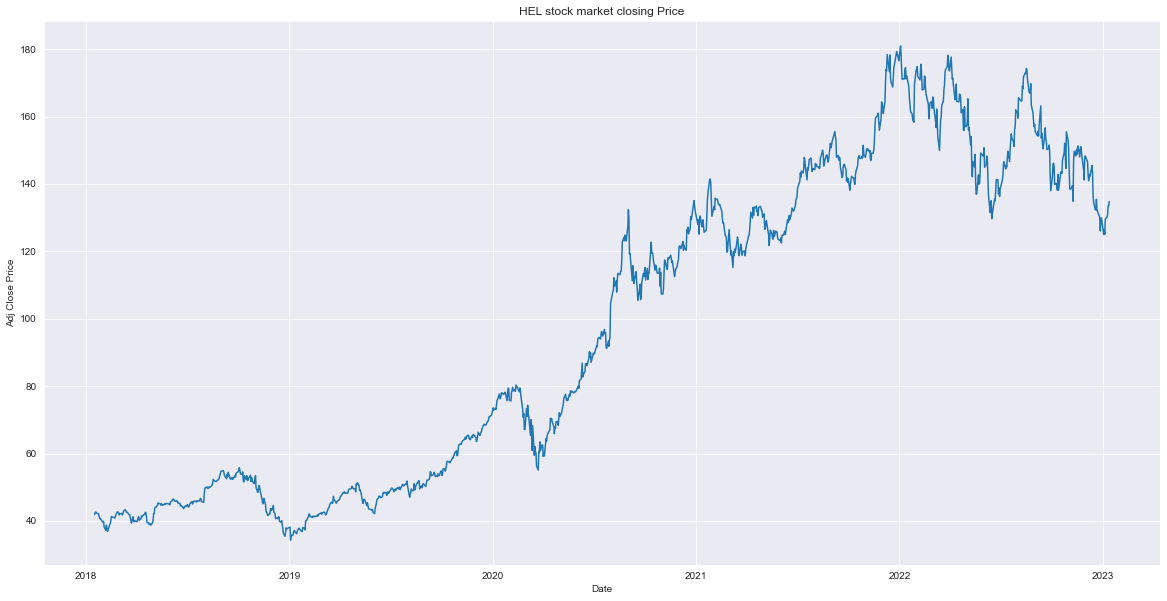

In [4]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('HEL stock market closing Price')
plt.plot(data['Adj Close'])

# Checking the stationarity

In [5]:
def test_adf(timeseries):
    
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()
    
    plt.figure(figsize=(20,10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(moving_average, color='red', label='Rolling Mean')
    plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of dickey fuller test')
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'Critical value {key}'] = value
    print(output)
    

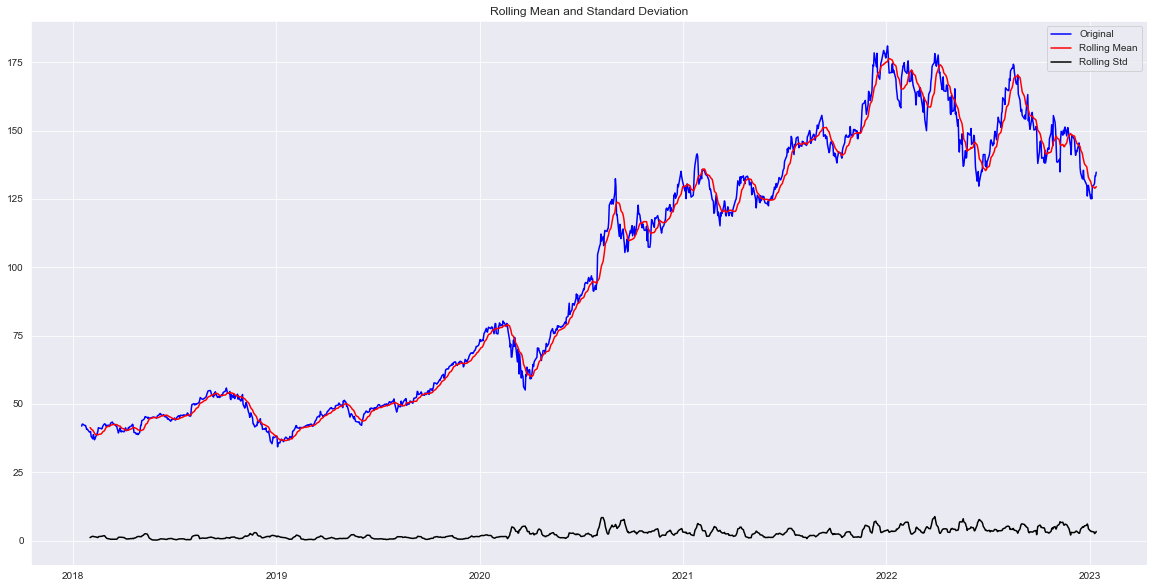

Results of dickey fuller test
Test Statistics                  -1.081323
p-value                           0.722462
No. of lags used                 11.000000
Number of observations used    1247.000000
Critical value 1%                -3.435605
Critical value 5%                -2.863861
Critical value 10%               -2.568005
dtype: float64


In [6]:
test_adf(data['Adj Close'])

In [7]:
data_adj_close = data['Adj Close'].tolist()

<Figure size 432x288 with 0 Axes>

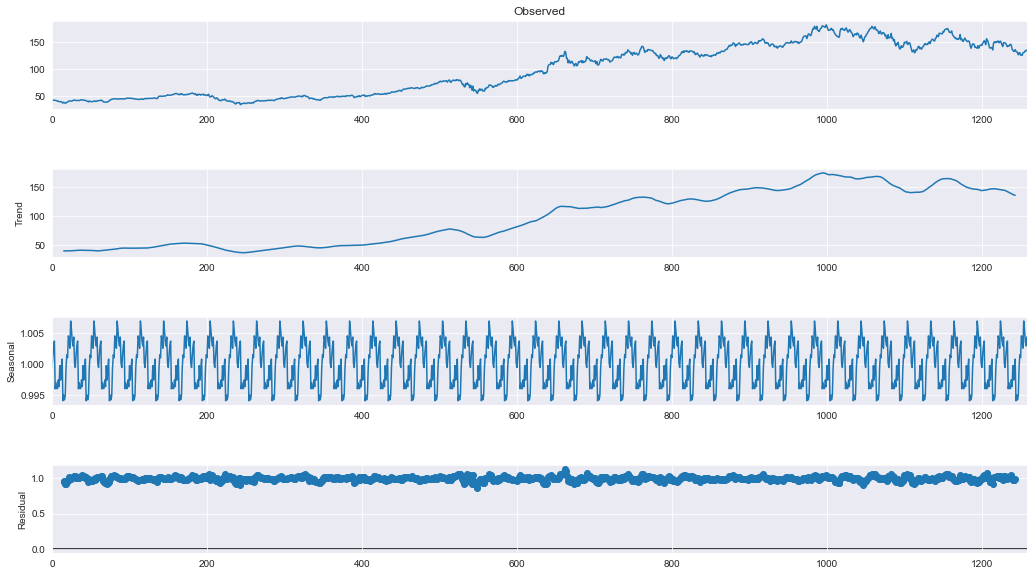

In [8]:
result = seasonal_decompose(data_adj_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

# Converting non-stationary to stationary data

In [9]:
data_adj_close_log = np.log(data_adj_close)
df_data_adj_close_log = pd.DataFrame({'Adj_Close': data_adj_close_log})
moving_average = df_data_adj_close_log.rolling(12).mean()
std_dev = df_data_adj_close_log.rolling(12).std()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


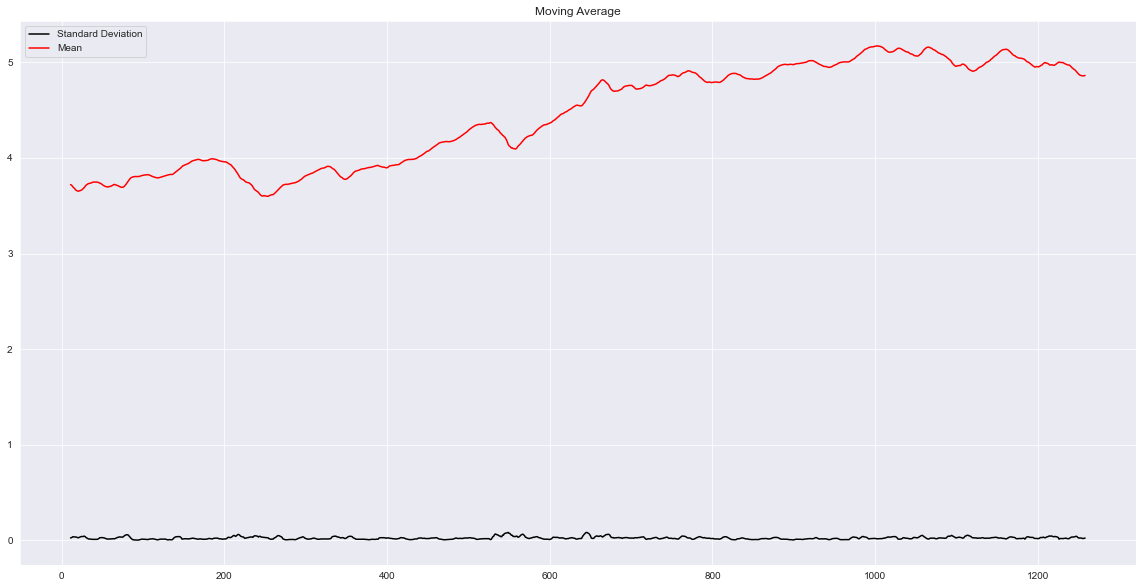

In [10]:
rcParams['figure.figsize'] = 20, 10
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_average, color='red', label='Mean')
plt.legend()
plt.show()

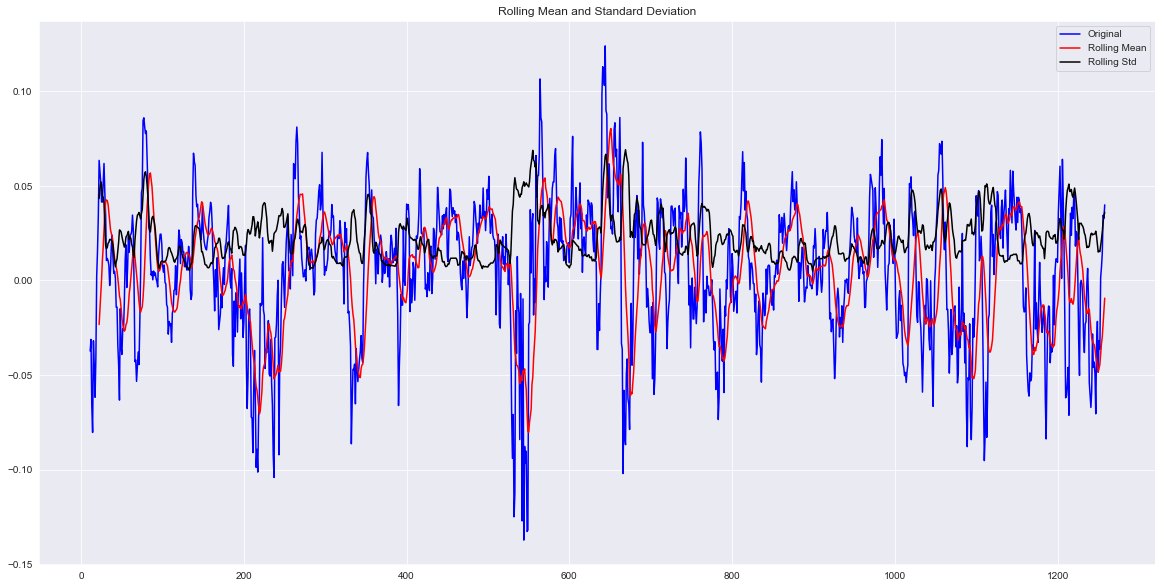

Results of dickey fuller test
Test Statistics               -6.975553e+00
p-value                        8.447067e-10
No. of lags used               1.100000e+01
Number of observations used    1.236000e+03
Critical value 1%             -3.435652e+00
Critical value 5%             -2.863881e+00
Critical value 10%            -2.568016e+00
dtype: float64


In [11]:
data_log_minus_mean = df_data_adj_close_log - moving_average
data_log_minus_mean.dropna(inplace=True)
test_adf(data_log_minus_mean)

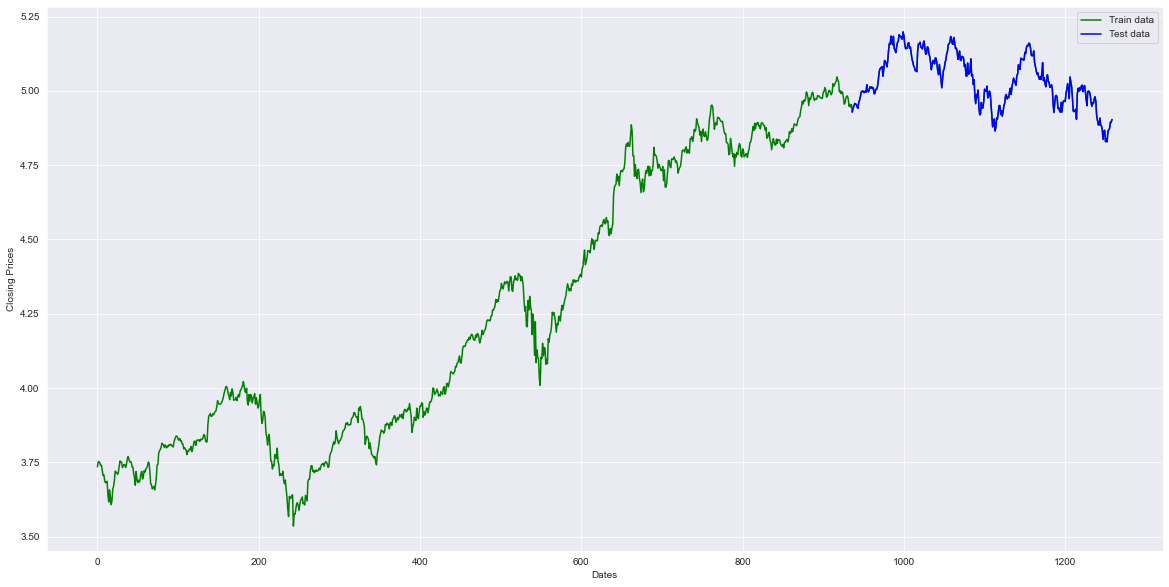

In [12]:
train_data, test_data = (df_data_adj_close_log[:int(len(data_adj_close_log)*0.75)], 
                         df_data_adj_close_log[int(len(data_log_minus_mean)*0.75):])
plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_adj_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# Auto ARIMA

In [13]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                                test='adf', max_p=7, max_q=7, m=1,
                                d=None, seasonal=False, start_P=0,
                                D=0, trace=True, error_action='ignore',
                                suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4599.013, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4616.902, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4615.929, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4597.548, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4615.172, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4615.211, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4612.911, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4614.297, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.782 seconds


# ARIMA

In [36]:
model = ARIMA(train_data, order=(1, 1, 0))
fitted = model.fit()

In [43]:
fitted.forecast(test_data.shape[0], alpha=0.05)

944     4.941472
945     4.941389
946     4.941400
947     4.941399
948     4.941399
          ...   
1262    4.941399
1263    4.941399
1264    4.941399
1265    4.941399
1266    4.941399
Name: predicted_mean, Length: 323, dtype: float64

In [37]:
fitted.conf_int()

,0,1
ar.L1,-0.179622,-0.101057
sigma2,0.000415,0.000459


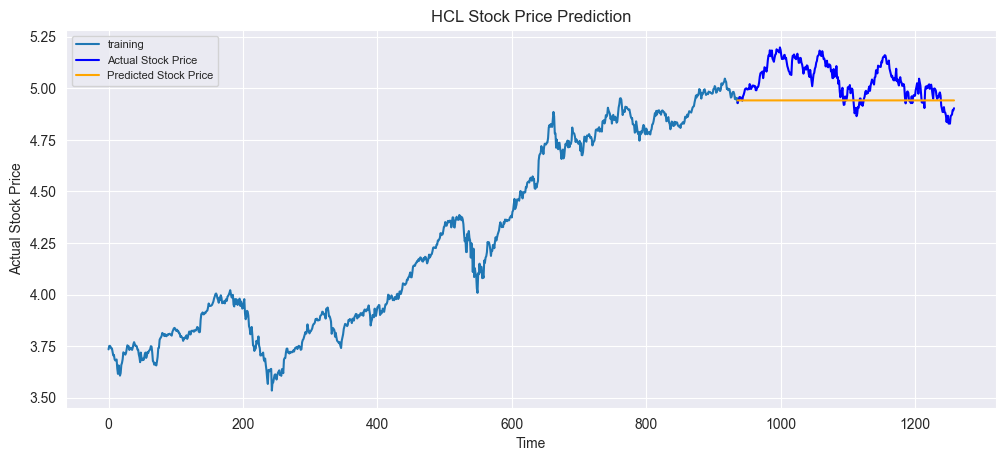

In [35]:
fc = fitted.forecast(test_data.shape[0], alpha=0.05)
conf = fitted.conf_int()
fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[0].to_list(), index=test_data.index)
# upper_series = pd.Series(conf[1].to_list(), index=test_data.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('HCL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()